In [7]:
from data.custom import CustomTrain, CustomTest
from models.vqgan import VQMultiModel
from data.utils import custom_collate
import torch

model = VQMultiModel.load_from_checkpoint("./tinyimagenet/model/last-v3.ckpt")
model.to("cuda")
model.eval()

dataset = CustomTrain(
            training_images_list_file="./tinyimagenet/train.txt",
            size=64
        )

img = custom_collate([dataset[1]])

print(img['image'].shape)


Working with z of shape (1, 1024, 16, 16) = 262144 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
torch.Size([1, 64, 64, 3])


In [8]:
x = model.get_input(custom_collate([dataset[0], dataset[1], dataset[2], dataset[3], dataset[4]]), model.image_key)

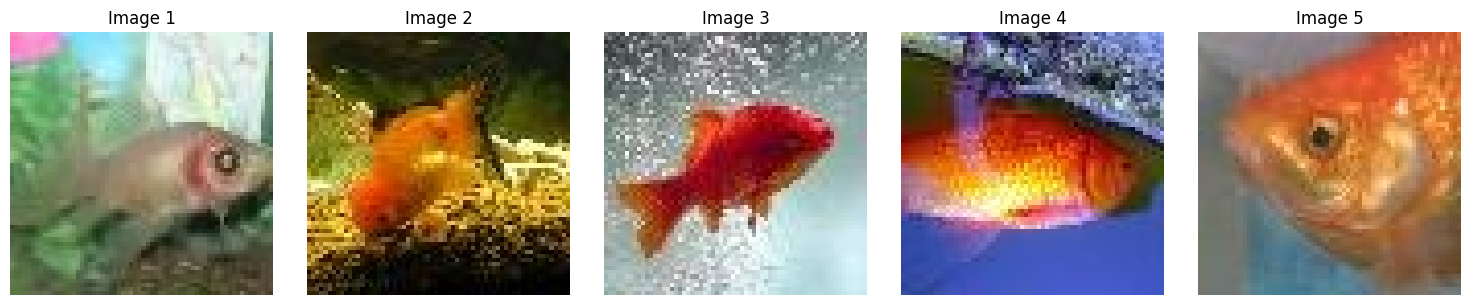

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Convert tensor to image format and move to CPU 
    img = x[i].permute(1,2,0).cpu().numpy()
    # Clip values to valid range
    img = (img * 0.5 + 0.5).clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

tensor([2037, 7769,  375, 7825, 7524, 2306,  298, 1291, 3706, 4509, 1036, 2597,
        3719,  283, 7036, 2878, 1187,   63, 5687, 5687], device='cuda:0')
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


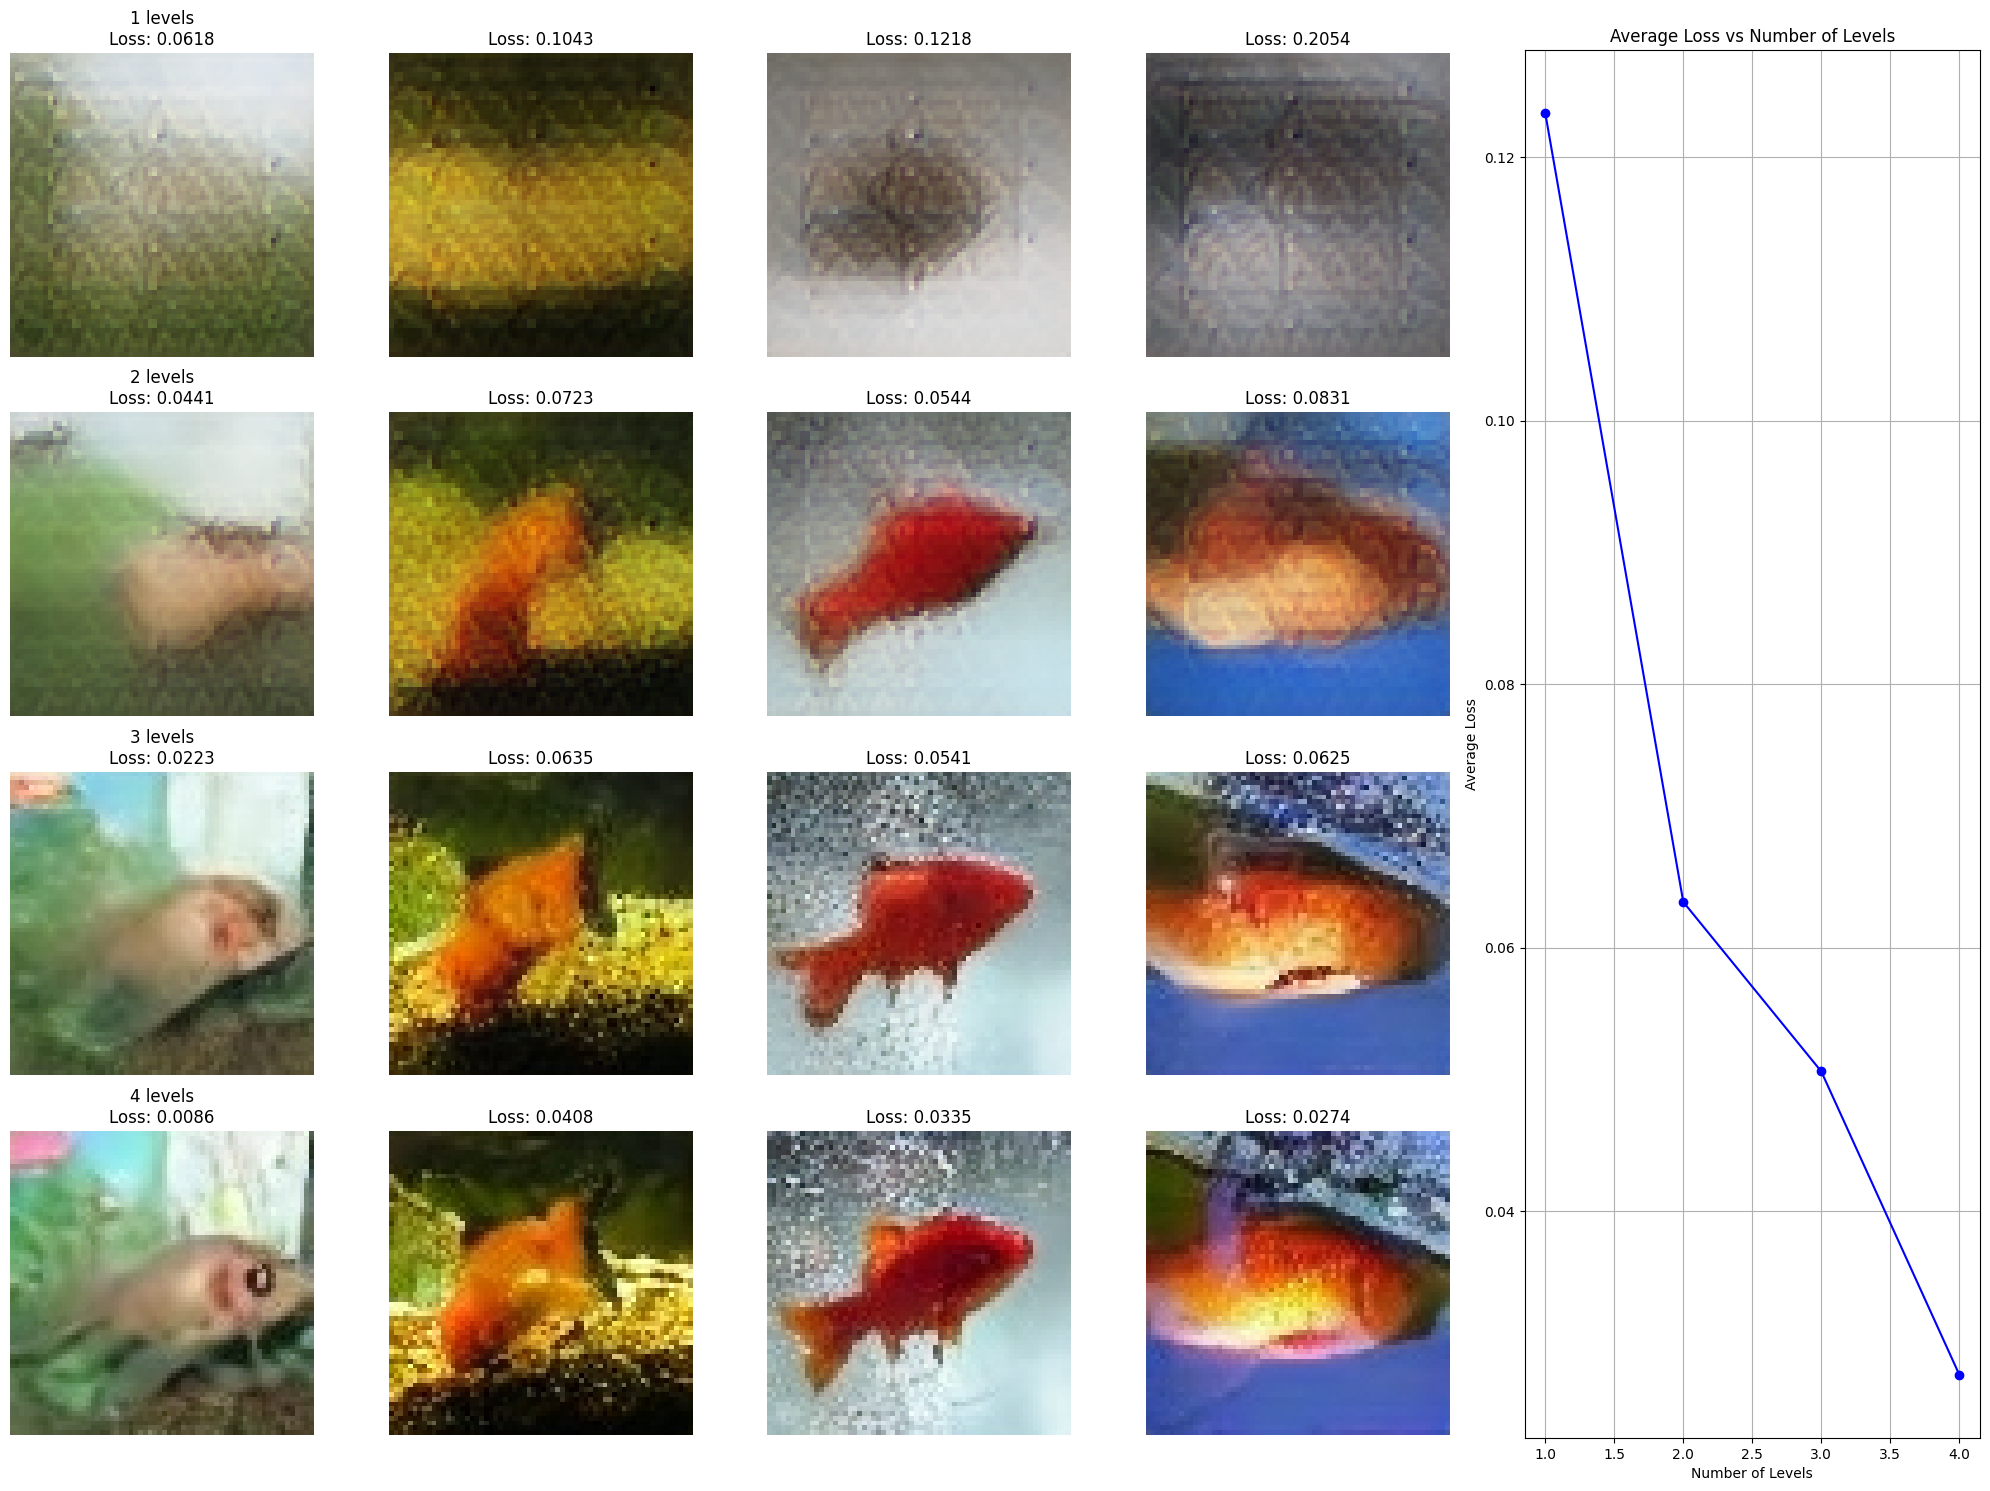

In [10]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    quant1, quant2, quant3, quant4, diff, info = model.encode(x.to("cuda"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    
    print(info4)
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0)

loss = VQLPIPSWithDiscriminatorInference()

# Create subplot grid with space for loss plot
gs = plt.GridSpec(4, 5, width_ratios=[1,1,1,1,1.5])

avg_losses = []

for i in range(images.shape[0]):  # For each level
    row_losses = []
    for j in range(4):  # For each image in batch
        plt.subplot(gs[i, j])
        # Convert tensor to image format and move to CPU
        img_j = images[i,j].permute(1,2,0).cpu().numpy()
        # Clip values to valid range
        img_j = (img_j * 0.5 + 0.5).clip(0, 1)
        plt.imshow(img_j)
        plt.axis('off')
        
        # Calculate and display loss
        # mse = loss(x[j].to("cpu"), images[i][j].to("cpu")).item()
        mse = torch.mean((x[j].to("cpu") - images[i][j].to("cpu")) ** 2).item()
        row_losses.append(mse)
        if j == 0:  # Only show level labels for first column
            plt.title(f'{i+1} levels\nLoss: {mse:.4f}')
        else:
            plt.title(f'Loss: {mse:.4f}')
    
    avg_losses.append(np.mean(row_losses))

# Plot average losses
plt.subplot(gs[:, 4])
plt.plot(range(1,5), avg_losses, 'bo-')
plt.xlabel('Number of Levels')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Number of Levels')
plt.grid(True)

plt.tight_layout()
plt.show()


In [1]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    quant1, quant2, quant3, quant4, diff, info = model.encode(x.to("mps"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    print(info4)
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,18)) # Made figure slightly taller for ground truth row
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0), x.to("mps").unsqueeze(0)], dim=0)

# Create subplot grid
gs = plt.GridSpec(5, 4) # Changed to 5 rows

patch_sizes = [32, 16, 8, 4, 4]  # Added patch size for ground truth

for i in range(images.shape[0]):  # For each level including ground truth
    for j in range(4):  # For each image in batch
        plt.subplot(gs[i, j])
        
        # Convert tensor to image format and move to CPU
        img_j = images[i,j].permute(1,2,0).cpu().numpy()
        # Clip values to valid range
        img_j = (img_j * 0.5 + 0.5).clip(0, 1)
        
        if i < 4:  # Only calculate patch losses for reconstructions
            # Calculate patch-wise losses
            patch_size = patch_sizes[i]
            h, w = img_j.shape[:2]
            loss_map = np.zeros((h//patch_size, w//patch_size))
            
            for pi in range(h//patch_size):
                for pj in range(w//patch_size):
                    x_patch = x[j,:,pi*patch_size:(pi+1)*patch_size,pj*patch_size:(pj+1)*patch_size].to("cpu")
                    y_patch = images[i,j,:,pi*patch_size:(pi+1)*patch_size,pj*patch_size:(pj+1)*patch_size].to("cpu")
                    # Calculate MSE loss for patch
                    patch_loss = torch.mean((x_patch - y_patch) ** 2).item()
                    loss_map[pi,pj] = patch_loss
                    
            # Normalize loss map for visualization
            loss_map = (loss_map - loss_map.min()) / (loss_map.max() - loss_map.min() + 1e-8)
            
            # Upsample loss map to image size
            loss_map_resized = np.repeat(np.repeat(loss_map[:,:,np.newaxis], patch_size, axis=0), patch_size, axis=1)
            
            # Add red tint based on loss map
            img_j_with_red = img_j.copy()
            img_j_with_red[:,:,0] = np.minimum(1.0, img_j[:,:,0] + loss_map_resized[:,:,0] * 0.5)
            
            plt.imshow(img_j_with_red)
            
            # Calculate MSE loss for whole image
            mse = torch.mean((x[j].to("cpu") - images[i][j].to("cpu")) ** 2).item()
            
            if j == 0:  # Only show level labels for first column
                plt.title(f'{i+1} levels\nMSE: {mse:.4f}')
            else:
                plt.title(f'MSE: {mse:.4f}')
        else:
            # Just display ground truth without loss visualization
            plt.imshow(img_j)
            if j == 0:
                plt.title('Ground Truth')
            else:
                plt.title('Ground Truth')
                
        plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'torch' is not defined

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
torch.Size([4, 5, 3, 64, 64])
tensor([1.0969, 1.3076, 1.1841, 1.2008], device='mps:0')
tensor([[0.4187, 0.4196],
        [0.4102, 0.3822]])
torch.Size([4, 5, 3, 64, 64])
tensor([1.0969, 1.3076, 1.1841, 1.2008], device='mps:0')
tensor([[0.7631, 0.7595, 0.7588, 0.7805],
        [0.7568, 0.7447, 0.7530, 0.7664],
        [0.7700, 0.7652, 0.7715, 0.7769],
        [0.7613, 0.7691, 0.7738, 0.7706]])
torch.Size([4, 5, 3, 64, 64])
tensor([1.0969, 1.3076, 1.1841, 1.2008], device='mps:0')
tensor([[0.7645, 0.7727, 0.7685, 0.7693, 0.7659, 0.7664, 0.7674, 0.7608],
        [0.7727, 0.7771, 0.7704, 0.7713, 0.7678, 0.7631, 0.7637, 0.7633],
        [0.7702, 0.7674, 0.7692, 0.7631, 0.7685, 0.7669, 0.7651, 0.7657],
        [0.7593, 0.7661, 0.7669, 0.7574, 0.7689, 0.7637, 0.7587, 0.7634],
        [0.7627, 0.7637, 0.7684, 0.7614, 0.7642, 0.7637, 0.7686, 0.7675],
        [0.7663, 0.7655, 0.7642, 0.7668, 0.7699, 0.7713, 0.7677, 0.7690]

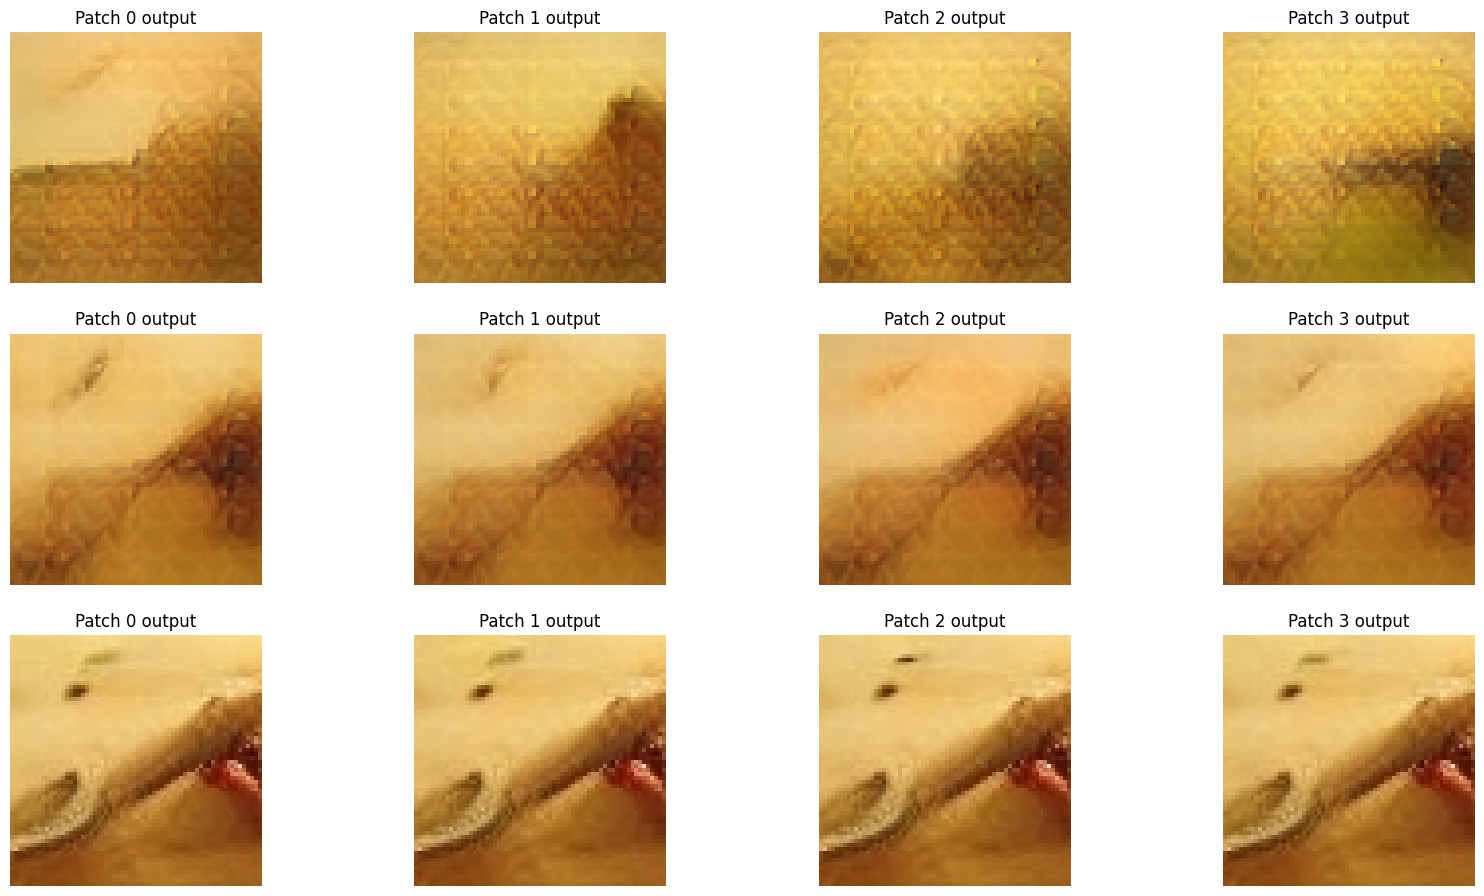

In [40]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    _, _, _, _, diff, info = model.encode(x.to("mps"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    quant1 = model.quantize_1.get_codebook_entry(info1, (5, 16, 16, 8))
    quant2 = model.quantize_2.get_codebook_entry(info2, (5, 8, 8, 8))
    quant3 = model.quantize_3.get_codebook_entry(info3, (5, 4, 4, 8))
    quant4 = model.quantize_4.get_codebook_entry(info4, (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0)
zeros = [zero1, zero2, zero3, zero4]
widths = [2,4,8,16]

loss = VQLPIPSWithDiscriminatorInference().to("mps")

patch_difficulties = [torch.zeros(5,2,2), torch.zeros(5,4,4), torch.zeros(5,8,8)]

# fourth level 2x2
patches = 0
x = x.to("mps")
print(images.shape)
base_loss = torch.Tensor([loss(x[i], images[i]) for i in range(4)]).to("mps")
print(base_loss)
for i in range(2):
    for j in range(2):
        levels = [zero1.clone(), zero2.clone(), zero3.clone(), quant4.clone()]
        levels[2][:, :, 2*i, 2*j] = quant3[:, :, 2*i, 2*j]
        levels[2][:, :, 2*i+1, 2*j] = quant3[:, :, 2*i+1, 2*j]
        levels[2][:, :, 2*i, 2*j+1] = quant3[:, :, 2*i, 2*j+1]
        levels[2][:, :, 2*i+1, 2*j+1] = quant3[:, :, 2*i+1, 2*j+1]
            
        with torch.no_grad():
            output = model.decode(levels[0], levels[1], levels[2], levels[3])
            detail_losses = torch.Tensor([loss(x[i], output[i]) for i in range(5)])
            difficulty = torch.Tensor([base_loss[0] - detail_losses[i] for i in range(5)])
            patch_difficulties[0][:,i,j] = difficulty
        
        if patches < 4:
            plt.subplot(4, 4, 1 + patches)
            plt.imshow((output[2].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
        
        patches += 1
print(patch_difficulties[0][0,:,:])

# third level 4x4
patches = 0
x = x.to("mps")
print(images.shape)
base_loss = torch.Tensor([loss(x[i], images[i]) for i in range(4)]).to("mps")
print(base_loss)
for i in range(4):
    for j in range(4):
        levels = [zero1.clone(), zero2.clone(), quant3.clone(), quant4.clone()]
        levels[1][:, :, 2*i, 2*j] = quant2[:, :, 2*i, 2*j]
        levels[1][:, :, 2*i+1, 2*j] = quant2[:, :, 2*i+1, 2*j]
        levels[1][:, :, 2*i, 2*j+1] = quant2[:, :, 2*i, 2*j+1]
        levels[1][:, :, 2*i+1, 2*j+1] = quant2[:, :, 2*i+1, 2*j+1]
            
        with torch.no_grad():
            output = model.decode(levels[0], levels[1], levels[2], levels[3])
            detail_losses = torch.Tensor([loss(x[i], output[i]) for i in range(5)])
            difficulty = torch.Tensor([base_loss[1] - detail_losses[i] for i in range(5)])
            patch_difficulties[1][:,i,j] = difficulty
        
        if patches < 4:
            plt.subplot(4, 4, 5 + patches)
            plt.imshow((output[2].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
            
        patches += 1
        
print(patch_difficulties[1][0,:,:])
# second level 8x8
patches = 0
x = x.to("mps")
print(images.shape)
base_loss = torch.Tensor([loss(x[i], images[i]) for i in range(4)]).to("mps")
print(base_loss)
for i in range(8):
    for j in range(8):
        levels = [zero1.clone(), quant2.clone(), quant3.clone(), quant4.clone()]
        levels[0][:, :, 2*i, 2*j] = quant1[:, :, 2*i, 2*j]
        levels[0][:, :, 2*i+1, 2*j] = quant1[:, :, 2*i+1, 2*j]
        levels[0][:, :, 2*i, 2*j+1] = quant1[:, :, 2*i, 2*j+1]
        levels[0][:, :, 2*i+1, 2*j+1] = quant1[:, :, 2*i+1, 2*j+1]
            
        with torch.no_grad():
            output = model.decode(levels[0], levels[1], levels[2], levels[3])
            detail_losses = torch.Tensor([loss(x[i], output[i]) for i in range(5)])
            difficulty = torch.Tensor([base_loss[2] - detail_losses[i] for i in range(5)])
            patch_difficulties[2][:,i,j] = difficulty
        
        if patches < 4:
            plt.subplot(4, 4, 9 + patches)
            plt.imshow((output[2].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
            plt.title(f"Patch {patches} output")
            plt.axis('off')
            
        patches += 1

print(patch_difficulties[2][0,:,:])


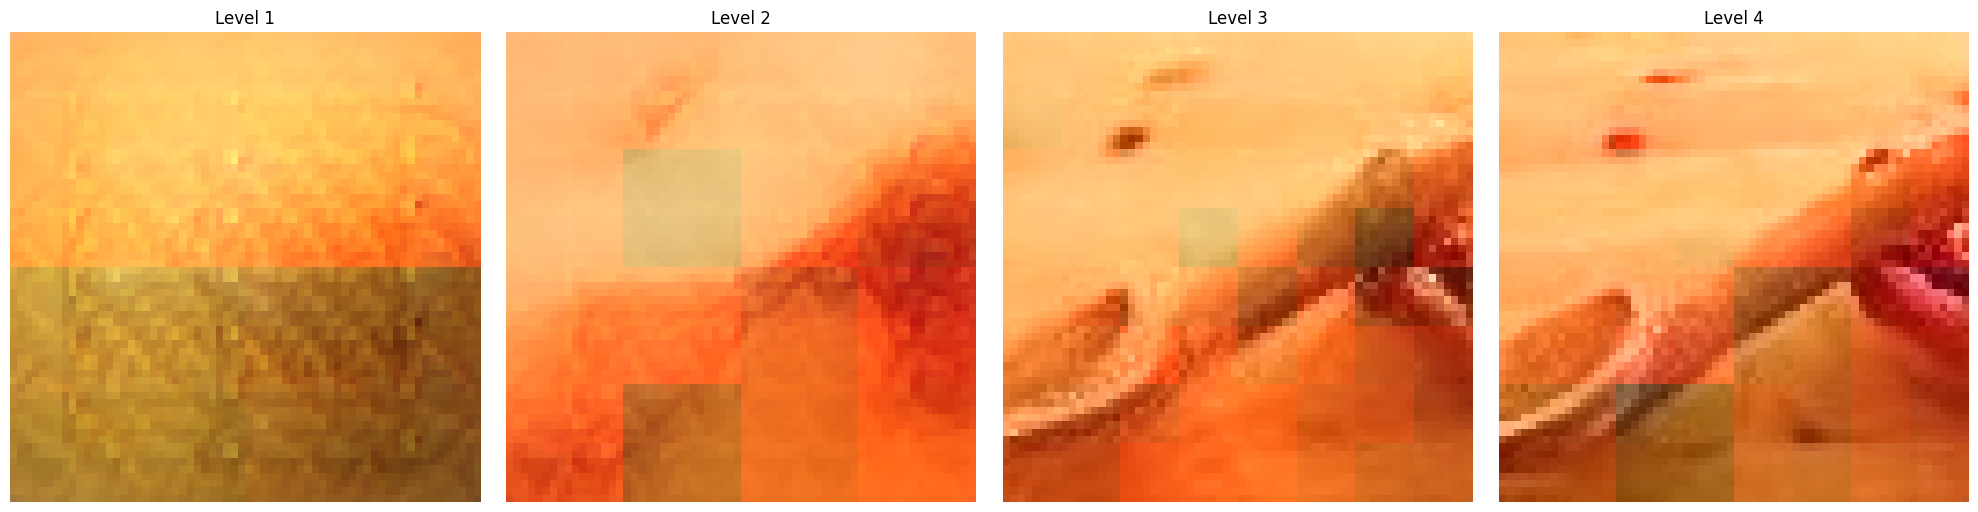

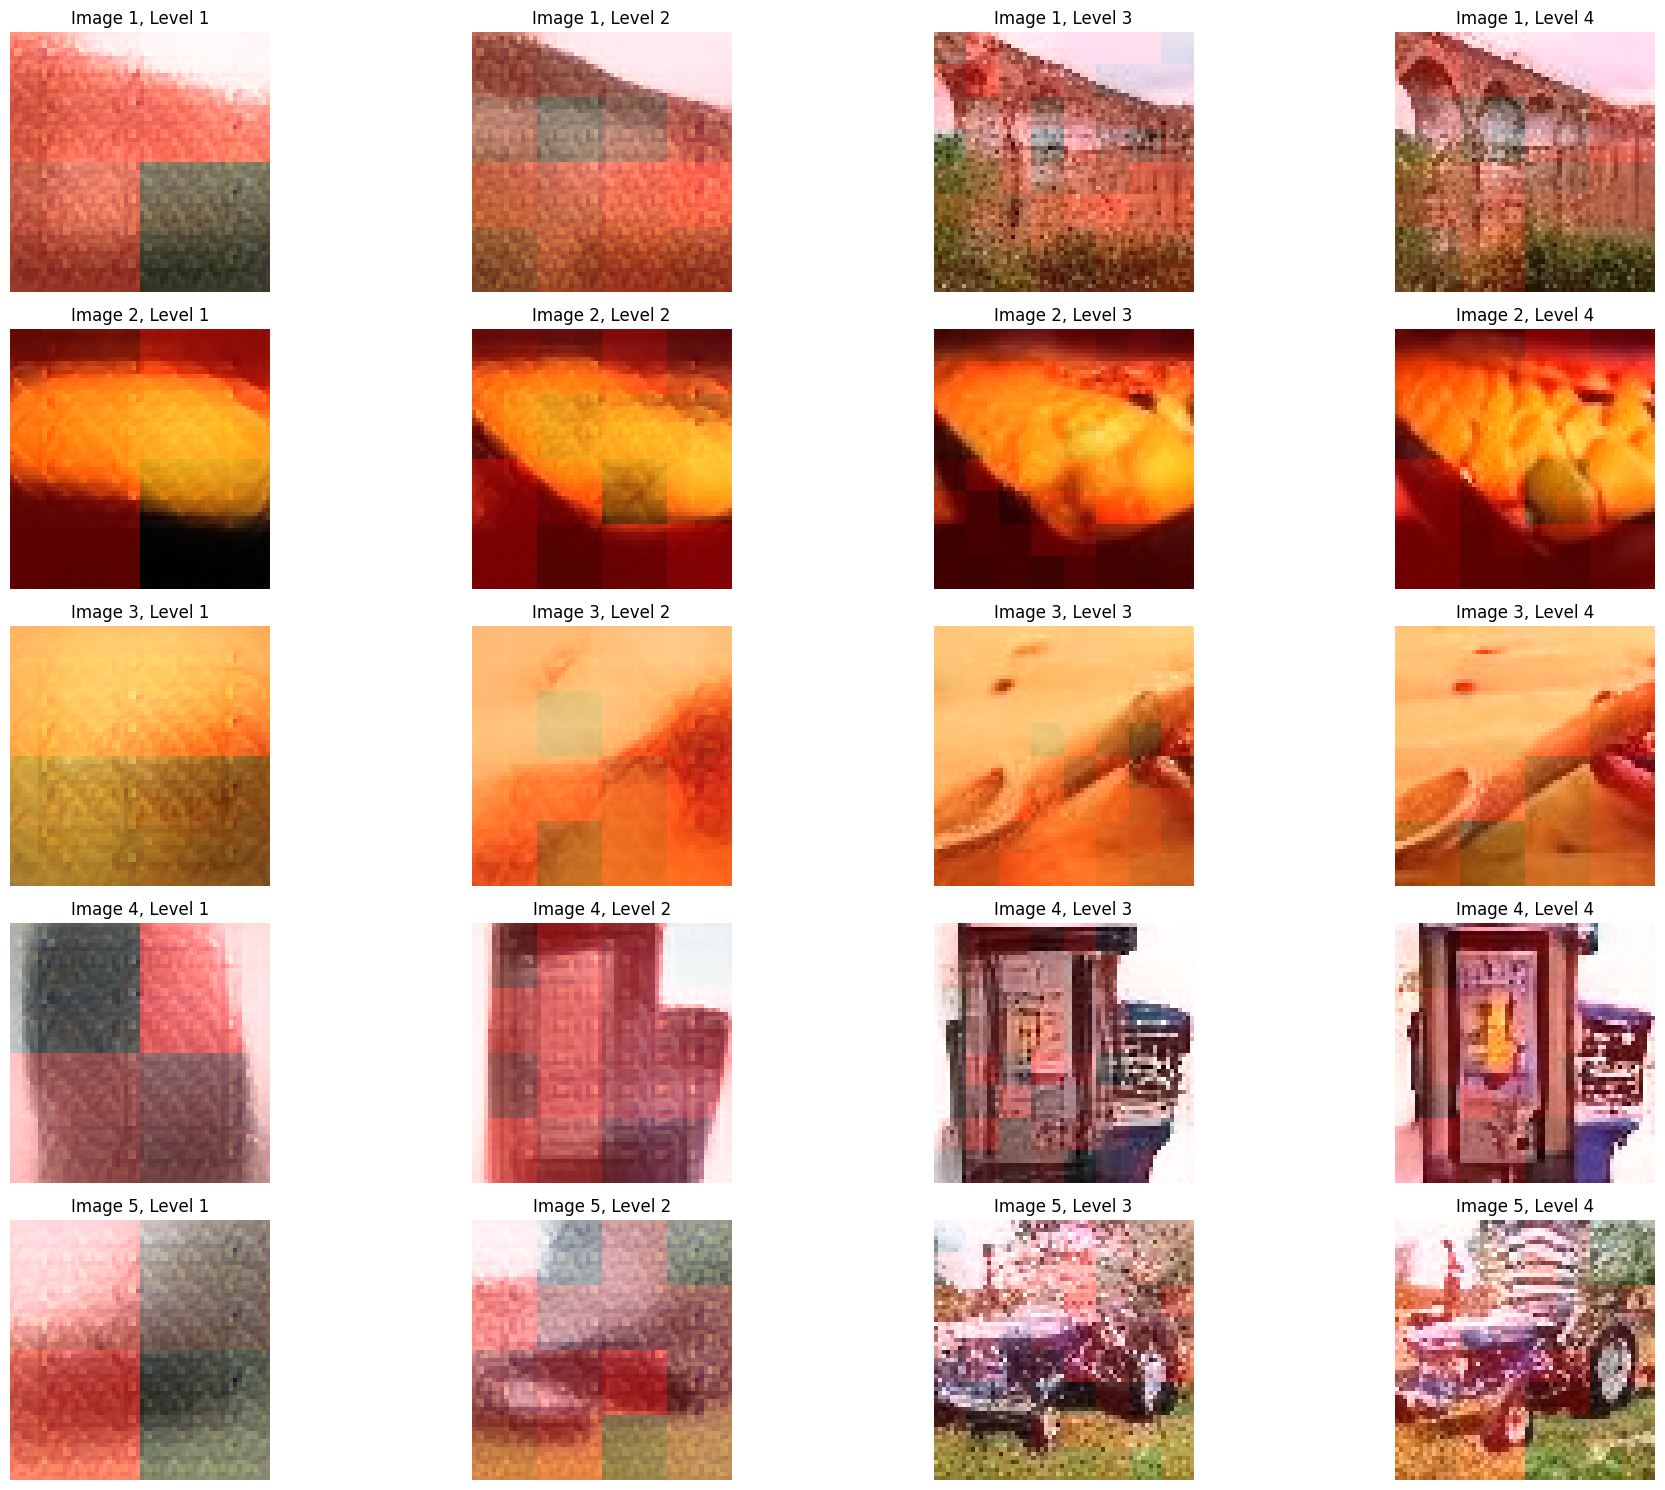

In [43]:
# Normalize patch difficulties for each level
for level in range(3):  # We have 3 levels of patch difficulties
    # Get min and max across all images for this level
    level_min = patch_difficulties[level].min()
    level_max = patch_difficulties[level].max()
    
    # Normalize to [0,1] range
    patch_difficulties[level] = (patch_difficulties[level] - level_min) / (level_max - level_min)

# Calculate cumulative difficulties for level 4
level4_difficulties = np.zeros((5, 64, 64))  # Changed to handle all 5 images
for img_idx in range(5):  # Loop through all images
    for i in range(8):
        for j in range(8):
            # Get parent patches from each level for this image
            level3_patch = patch_difficulties[2][img_idx,i,j].cpu().numpy()
            level2_patch = patch_difficulties[1][img_idx,i//2,j//2].cpu().numpy()
            level1_patch = patch_difficulties[0][img_idx,i//4,j//4].cpu().numpy()
            
            # Sum up difficulties from all parent patches
            cumulative_difficulty = level1_patch + level2_patch + level3_patch
            
            # Map to 8x8 region in final difficulty map for this image
            level4_difficulties[img_idx,i*8:(i+1)*8, j*8:(j+1)*8] = cumulative_difficulty

plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = (images[i,2].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    
    # Create red overlay from patch difficulties
    if i < 3:  # First 3 levels have patch difficulties
        difficulties = patch_difficulties[i][2].cpu().numpy()  # Using image index 2
        # Scale up difficulties to image size using nearest neighbor interpolation
        scaled_difficulties = np.repeat(np.repeat(difficulties, 64//difficulties.shape[0], axis=0), 
                                      64//difficulties.shape[1], axis=1)
        # Normalize difficulties to [0,1] range
        scaled_difficulties = (scaled_difficulties - scaled_difficulties.min()) / (scaled_difficulties.max() - scaled_difficulties.min())
        # Add red channel overlay
        img[:,:,0] = np.clip(img[:,:,0] + scaled_difficulties * 0.5, 0, 1)
    elif i == 3:  # Fourth level uses cumulative difficulties
        # Normalize cumulative difficulties for this image
        difficulties = level4_difficulties[2]  # Using image index 2
        scaled_difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())
        # Add red channel overlay
        img[:,:,0] = np.clip(img[:,:,0] + scaled_difficulties * 0.5, 0, 1)
        
    plt.imshow(img)
    plt.title(f"Level {i+1}")
    plt.axis('off')
plt.tight_layout()

# Now create a row of visualizations for each image
plt.figure(figsize=(20,15))
for img_idx in range(5):  # Loop through all images
    for level in range(4):  # 4 levels of visualization per image
        plt.subplot(5, 4, img_idx*4 + level + 1)
        img = (images[level,img_idx].permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        
        if level < 3:  # First 3 levels have patch difficulties
            difficulties = patch_difficulties[level][img_idx].cpu().numpy()
            scaled_difficulties = np.repeat(np.repeat(difficulties, 64//difficulties.shape[0], axis=0), 
                                          64//difficulties.shape[1], axis=1)
            scaled_difficulties = (scaled_difficulties - scaled_difficulties.min()) / (scaled_difficulties.max() - scaled_difficulties.min())
            img[:,:,0] = np.clip(img[:,:,0] + scaled_difficulties * 0.5, 0, 1)
        elif level == 3:  # Fourth level uses cumulative difficulties
            difficulties = level4_difficulties[img_idx]
            scaled_difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())
            img[:,:,0] = np.clip(img[:,:,0] + scaled_difficulties * 0.5, 0, 1)
            
        plt.imshow(img)
        plt.title(f"Image {img_idx+1}, Level {level+1}")
        plt.axis('off')
plt.tight_layout()


tensor([[[0.7078, 0.7100],
         [0.6878, 0.6224]],

        [[0.9669, 1.0000],
         [0.9712, 0.9050]],

        [[0.7177, 0.6673],
         [0.5409, 0.5585]],

        [[0.0000, 0.0266],
         [0.0143, 0.0100]],

        [[0.4460, 0.4184],
         [0.4605, 0.4106]]])


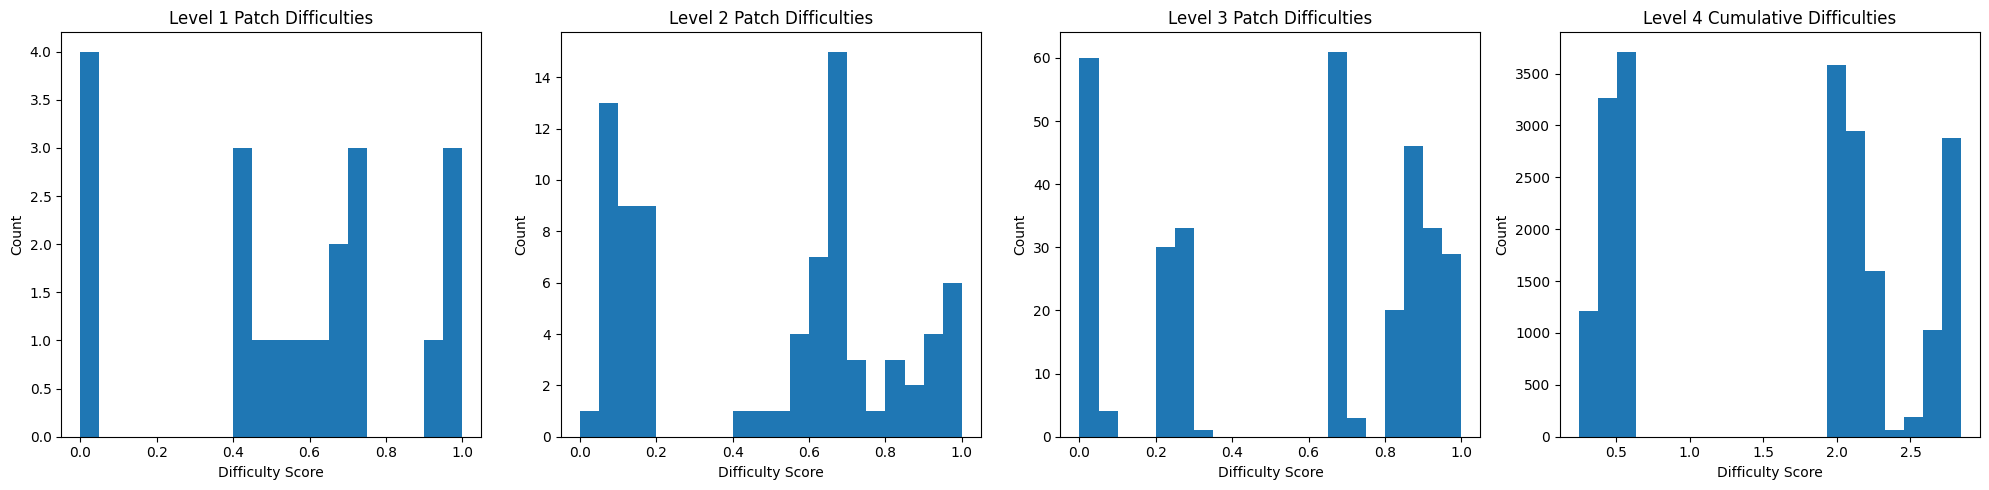

In [48]:
# Create histograms of patch difficulties across all images
plt.figure(figsize=(20,5))
for level in range(3):  # For each level
    plt.subplot(1,4,level+1)
    
    # Collect all patch difficulties for this level across images
    all_difficulties = []
    for img_idx in range(5):  # For each image
        difficulties = patch_difficulties[level][img_idx].cpu().numpy().flatten()
        all_difficulties.extend(difficulties)
        
    plt.hist(all_difficulties, bins=20)
    plt.title(f"Level {level+1} Patch Difficulties")
    plt.xlabel("Difficulty Score")
    plt.ylabel("Count")

# Add histogram for level 4 cumulative difficulties
plt.subplot(1,4,4)
all_difficulties = []
for img_idx in range(5):
    difficulties = level4_difficulties[img_idx].flatten()
    all_difficulties.extend(difficulties)
plt.hist(all_difficulties, bins=20)
plt.title("Level 4 Cumulative Difficulties") 
plt.xlabel("Difficulty Score")
plt.ylabel("Count")

plt.tight_layout()

print(patch_difficulties[0])

In [37]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    quant1, quant2, quant3, quant4, diff, info = model.encode(x.to("mps"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0).to("cpu")
zeros = [zero1, zero2, zero3, zero4]

loss = VQLPIPSWithDiscriminatorInference()

widths = [32, 16, 8, 4]
for image in range(2,3):
    patch_difficulties = [torch.zeros(2,2), torch.zeros(4,4), torch.zeros(8,8)]
    for level in range(3):
        patches = 0
        original = x[image]
        base = images[level, image]
        base_loss = loss(original, base)
        
        # Plot base image in first column
        plt.subplot(4, 5, level*5 + 1)
        plt.imshow((base.permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        plt.title(f"Base loss {base_loss.item():.4f}")
        plt.axis('off')
        
        # Calculate all patches but only plot first 4
        width = widths[level]

        
        for i in range(64//widths[level]):
            for j in range(64//widths[level]):
                detail = images[level, image].clone()
                detail[:, i * width: (i + 1) * width, j * width: (j + 1) * width] = images[level + 1, image][:, i * width: (i + 1) * width, j * width: (j + 1) * width]
                detail_loss = loss(original, detail)
                difficulty = base_loss - detail_loss
                patch_difficulties[level][i,j] = difficulty
                
                # Only plot first 4 patches
                if patches < 4:
                    plt.subplot(4, 5, level*5 + patches + 2)
                    plt.imshow((detail.permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
                    plt.title(f"Detail {patches} difficulty {difficulty.item():.4f}")
                    plt.axis('off')
                patches += 1
                
    # Create a new figure for visualizing patch difficulties
    plt.figure(figsize=(20,15))

    # Get original image
    original_img = x[image].permute(1,2,0).cpu().numpy() * 0.5 + 0.5

    # Plot combined histogram
    plt.subplot(2,1,1)
    colors = ['red', 'green', 'blue']
    labels = ['Level 0', 'Level 1', 'Level 2']
    for level in range(3):
        difficulties = patch_difficulties[level].cpu().numpy().flatten()
        plt.hist(difficulties, bins=20, alpha=0.5, color=colors[level], label=labels[level])
    plt.title("Patch Difficulty Distribution Across Levels")
    plt.xlabel("Difficulty Score")
    plt.ylabel("Count") 
    plt.legend()

    # Show original image below
    plt.subplot(2,1,2)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

<Figure size 2000x1500 with 0 Axes>

/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sprucecampbell/Documents/ai/ndp/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


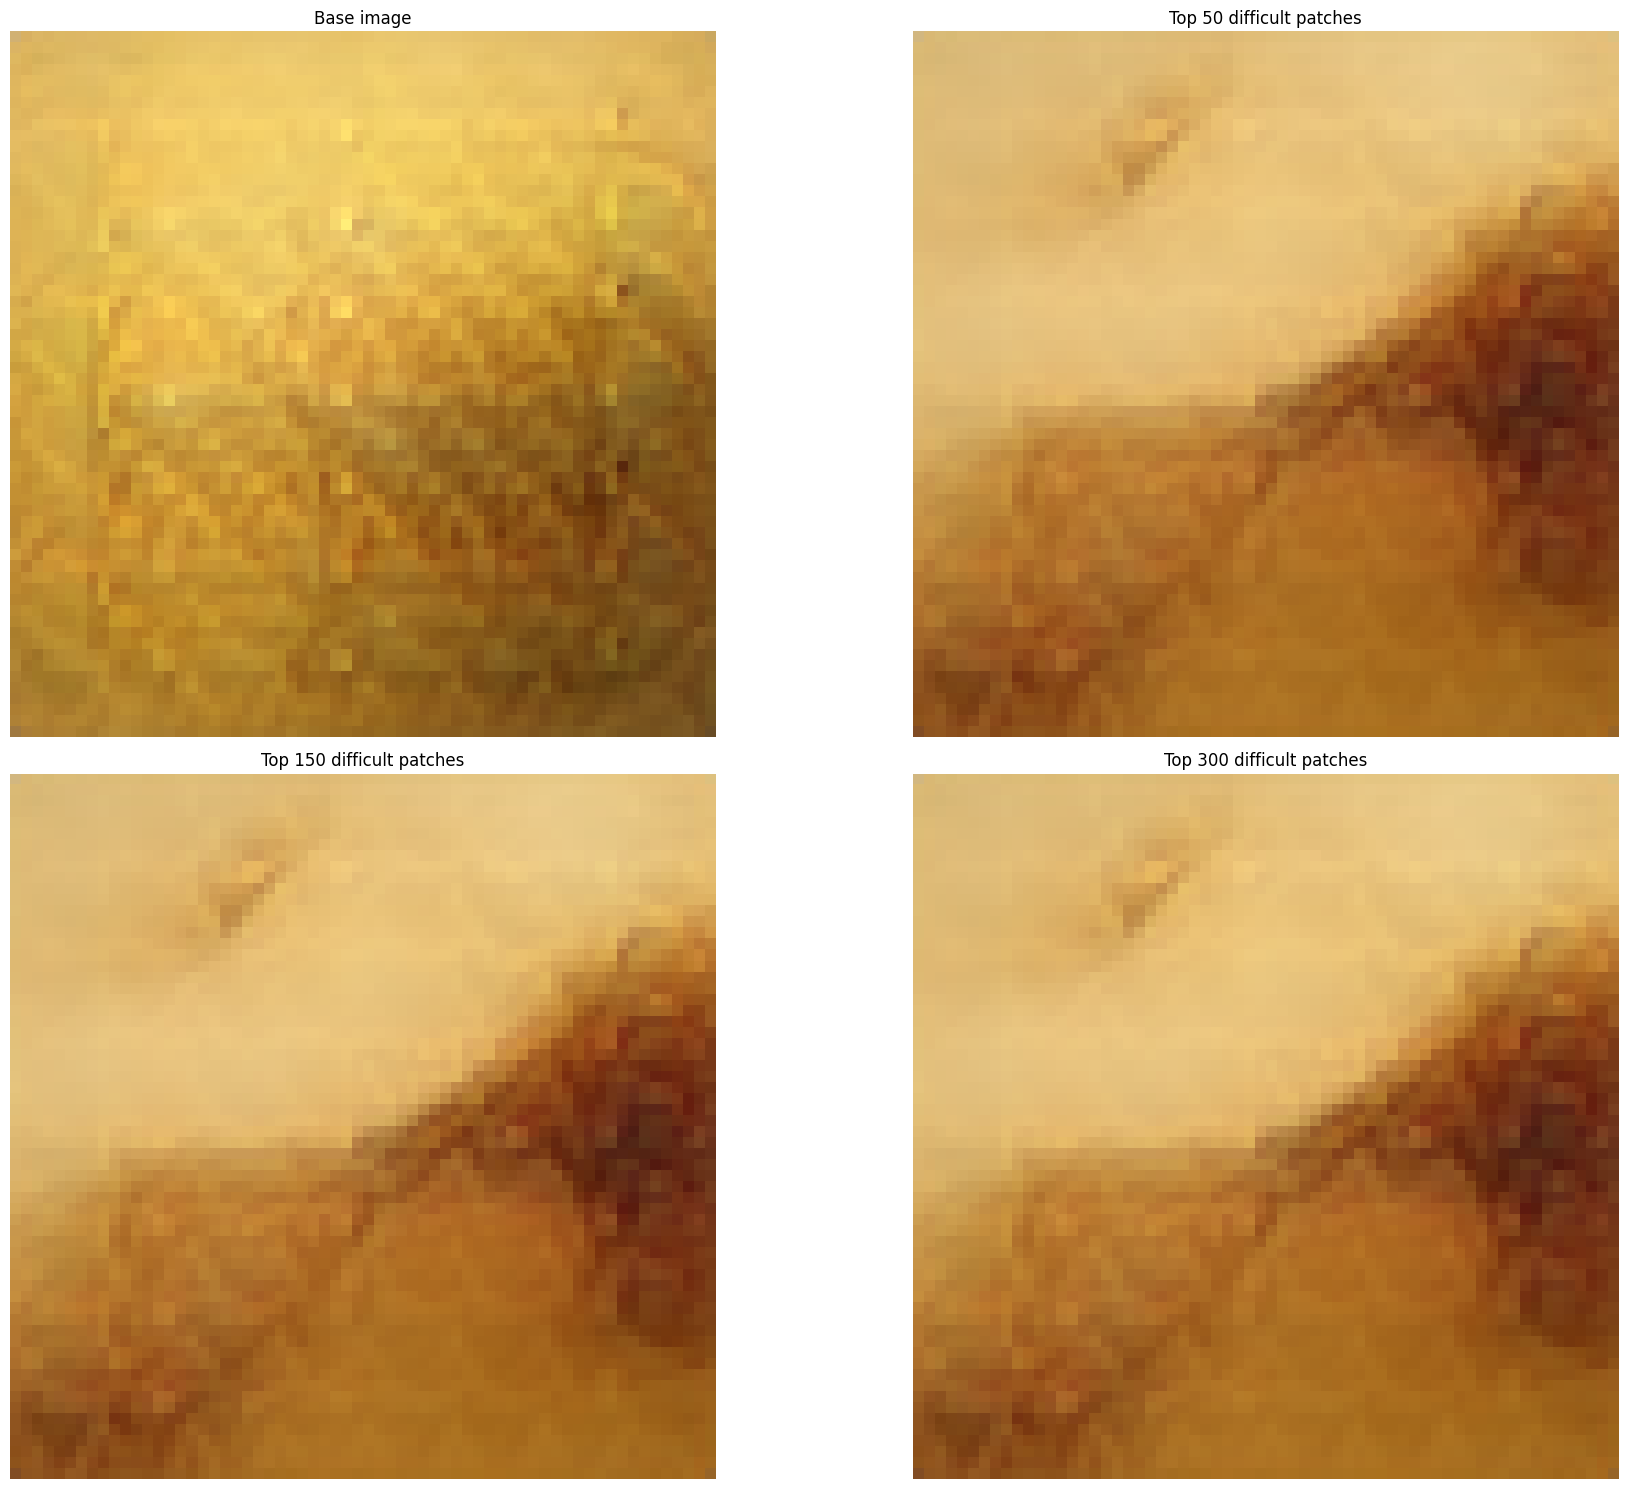

In [64]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    quant1, quant2, quant3, quant4, diff, info = model.encode(x.to("mps"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0).to("cpu")

loss = VQLPIPSWithDiscriminatorInference()

image = 2  # Looking at single image
level = 0  # Starting with top level
width = 32  # Width for top level patches

# Calculate difficulties for all patches
patch_difficulties = []
patch_coords = []
base = images[level, image]
original = x[image]
base_loss = loss(original, base)

for i in range(64//width):
    for j in range(64//width):
        detail = base.clone()
        detail[:, i * width: (i + 1) * width, j * width: (j + 1) * width] = images[level + 1, image][:, i * width: (i + 1) * width, j * width: (j + 1) * width]
        detail_loss = loss(original, detail)
        difficulty = base_loss - detail_loss
        patch_difficulties.append(difficulty.item())
        patch_coords.append((i,j))

# Sort patches by difficulty
sorted_indices = np.argsort(patch_difficulties)[::-1]  # Descending order

# Plot base and progressively more detailed versions
versions = [0, 50, 150, 300]  # Number of patches to replace
for idx, num_patches in enumerate(versions):
    plt.subplot(2, 2, idx+1)
    
    if num_patches == 0:
        plt.imshow((base.permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        plt.title(f"Base image")
    else:
        detail = base.clone()
        # Get coordinates for selected patches
        selected_patches = sorted_indices[:num_patches]
        # Sort by patch level (larger coordinates first)
        selected_patches = sorted(selected_patches, key=lambda x: (-max(patch_coords[x][0], patch_coords[x][1])))
        
        for patch_idx in selected_patches:
            i,j = patch_coords[patch_idx]
            detail[:, i * width: (i + 1) * width, j * width: (j + 1) * width] = images[level + 1, image][:, i * width: (i + 1) * width, j * width: (j + 1) * width]
        plt.imshow((detail.permute(1,2,0).cpu().numpy() * 0.5 + 0.5).clip(0, 1))
        plt.title(f"Top {num_patches} difficult patches")
    plt.axis('off')

plt.tight_layout()
plt.show()

tensor([2258, 1794, 1287, 2612, 2346, 4412, 5783, 6539, 2288, 3901, 1342, 3986,
         601, 3233, 2943, 2417, 2097, 7668, 1334, 3036], device='cuda:0')
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


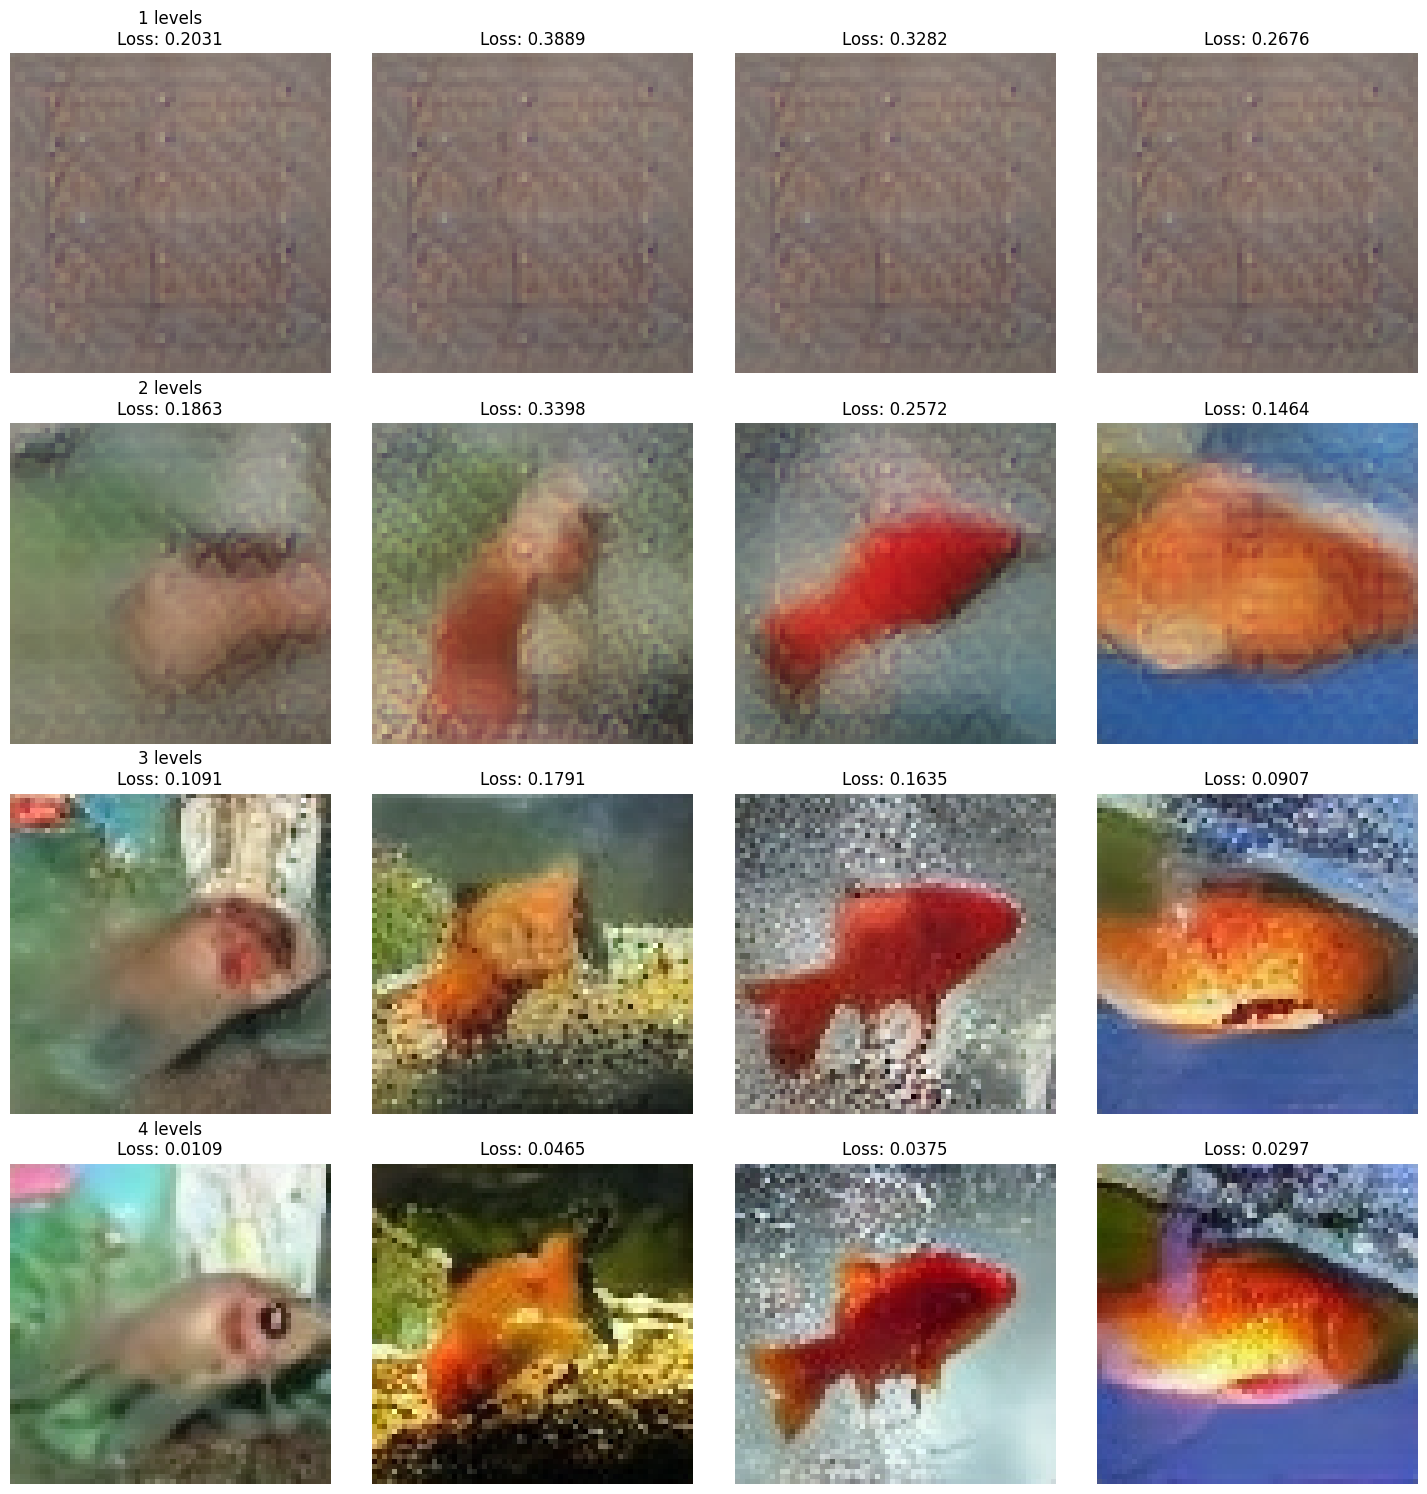

In [16]:
import numpy as np
from modules.losses.vqperceptual import VQLPIPSWithDiscriminatorInference
with torch.no_grad():
    quant1, quant2, quant3, quant4, diff, info = model.encode(x.to("cuda"))
    (_, _, info1), (_, _, info2), (_, _, info3), (_, _, info4) = info
    
    zero1 = model.quantize_1.get_codebook_entry(torch.zeros_like(info1), (5, 16, 16, 8))
    zero2 = model.quantize_2.get_codebook_entry(torch.zeros_like(info2), (5, 8, 8, 8))
    zero3 = model.quantize_3.get_codebook_entry(torch.zeros_like(info3), (5, 4, 4, 8))
    info4 = torch.randint(0, 8192, (5*4,), device="cuda")
    print(info4)
    zero4 = model.quantize_4.get_codebook_entry(torch.zeros_like(info4), (5, 2, 2, 8))
    
    quant4 = model.quantize_4.get_codebook_entry(info4, (5, 2, 2, 8))
    
    # Generate reconstructions with progressively more tokens
    y1 = model.decode(zero1, zero2, zero3, quant4)
    y2 = model.decode(zero1, zero2, quant3, quant4)
    y3 = model.decode(zero1, quant2, quant3, quant4)
    y4 = model.decode(quant1, quant2, quant3, quant4)

# Set up subplot grid
plt.figure(figsize=(20,15))
images = torch.cat([y1.unsqueeze(0), y2.unsqueeze(0), y3.unsqueeze(0), y4.unsqueeze(0)], dim=0)

loss = VQLPIPSWithDiscriminatorInference()

# Create subplot grid with space for loss plot
gs = plt.GridSpec(4, 5, width_ratios=[1,1,1,1,1.5])

avg_losses = []

for i in range(images.shape[0]):  # For each level
    row_losses = []
    for j in range(4):  # For each image in batch
        plt.subplot(gs[i, j])
        # Convert tensor to image format and move to CPU
        img_j = images[i,j].permute(1,2,0).cpu().numpy()
        # Clip values to valid range
        img_j = (img_j * 0.5 + 0.5).clip(0, 1)
        plt.imshow(img_j)
        plt.axis('off')
        
        # Calculate and display loss
        # mse = loss(x[j].to("cpu"), images[i][j].to("cpu")).item()
        mse = torch.mean((x[j].to("cpu") - images[i][j].to("cpu")) ** 2).item()
        row_losses.append(mse)
        if j == 0:  # Only show level labels for first column
            plt.title(f'{i+1} levels\nLoss: {mse:.4f}')
        else:
            plt.title(f'Loss: {mse:.4f}')
    
    avg_losses.append(np.mean(row_losses))

plt.tight_layout()
plt.show()
